Do this:  
```
pip install mysql-connector-python
```

In [9]:
import mysql.connector
import getpass
import pandas as pd
import tqdm
import json
from matplotlib import pyplot as plt
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


# connect to mysql server using python

In [2]:
# connect to my local mysql server
my_pokemon = mysql.connector.connect(
    host="localhost", 
    user="root", 
    password=getpass.getpass("password"),
    port=3306, 
    database="MyPokemon"
)

# test query
mycursor = my_pokemon.cursor(buffered=True)
mycursor.execute("SELECT * FROM pokemon LIMIT 5")
[print(i) for i in mycursor]

[]

# insert data using python
assuming the data collect is done and all we have is some excel and json files (data collection)  -> Extract  
here is the process to insert data from the collected data (could be dirty),  
but before that we need to make them fit in with the table we create -> transform  
then we upload them -> load

(in fact, the excel file is an outcome of ELT -> ETL)

In [3]:
# completing the table, ETL (treating the xlsx as the extracted data, then transform into the format to match the table)
excel_path = "data.xlsx"
all_pokemons = pd.read_excel(excel_path)

# have a look
all_pokemons.head()

,Unnamed: 0.1,Unnamed: 0,Id,Name,Icon,Type(s),TotalBS,HP,Attack,Defense,Special Attack,Special Defense,Speed,Number of battles,Number of wins,Win rates
0,0,0,1,Bulbasaur,./pokemon_icons/1. Bulbasaur.jpg,"['GRASS', 'POISON']",318,45,49,49,65,65,45,3.0,2.0,0.666667
1,1,1,2,Ivysaur,./pokemon_icons/2. Ivysaur.jpg,"['GRASS', 'POISON']",405,60,62,63,80,80,60,33.0,25.0,0.757576
2,2,2,3,Venusaur,./pokemon_icons/3. Venusaur.jpg,"['GRASS', 'POISON']",525,80,82,83,100,100,80,184.0,127.0,0.690217
3,3,3,3,Mega Venusaur,./pokemon_icons/3. Mega Venusaur.jpg,"['GRASS', 'POISON']",625,80,100,123,122,120,80,NaN,NaN,NaN
4,4,4,4,Charmander,./pokemon_icons/4. Charmander.jpg,['FIRE'],309,39,52,43,60,50,65,9.0,7.0,0.777778


In [4]:
# transform
rows = []
keep_columns = ['Id', 'Name', 'Type(s)', 'HP', 'Attack', 'Defense', 'Special Attack', 'Special Defense', 'Speed']

for i, row in all_pokemons.iterrows():
    row = [
        v if k != 'Type(s)' else eval(v) 
        for k, v in row.items() 
        if k in keep_columns
    ]  # use list here as tuple is immutable
    # deal with the type
    if len(row[2]) == 1:  # only 1 type
        types = row.pop(2)
        row.insert(2, types[0])
        row.insert(3, "Null")
    elif len(row[2]) == 2:  # 2 types
        types = row.pop(2)
        row.insert(2, types[0])
        row.insert(3, types[1])
    rows.append(row)

In [5]:
# load, insert them into my db
def insert_to_table(connector, cursor, table, columns, values):
    '''
    this function assumes user to know what columns are needed, 
    later on i will come back for more
    '''
    # cast all items in values into string XXX
    values = [f'"{v}"' if isinstance(v, str) and v != "Null" else str(v) for v in values]
    # create the insert sql XXX (better to construct the sql with in cursor.execute())
    query_str = f"INSERT INTO {table} ({', '.join(iter(columns))}) VALUES ({', '.join(iter(values))})"
    # print(query_str, end="\r")
    # execute
    try:
        cursor.execute(query_str)
        connector.commit()  # push to the database
    except mysql.connector.Error as err:
        raise err


keys = ['pokedex_id', 'pokemon_name', 'type_1', 'type_2', 'HP',
        'Attack', 'Defense', 'Special_Attack', 'Special_Defense', 'Speed']
for row in tqdm.tqdm(rows):
    insert_to_table(my_pokemon, mycursor, table='pokemon',
                    columns=keys, values=row)


100%|██████████| 1045/1045 [00:00<00:00, 2360.48it/s]


# insert battle data
but some of the battle data use a different set of pokemon names so I will need to somehow convert them. 

In [10]:
battle_path = '../1. data/showdown/match_data.json'
battle = pd.read_json(battle_path)

# key is alias, value is the name in the sql server
alias_path = '../1. data/showdown/alias.json'
with open(alias_path, 'r') as f: 
    alias_name = json.load(f)

# change all alias names
for i, row in battle.iterrows():
    if row['pokemon1'] in alias_name.keys(): 
        battle.at[i, 'pokemon1'] =  alias_name[row['pokemon1']]
    if row['pokemon2'] in alias_name.keys(): 
        battle.at[i, 'pokemon2'] =  alias_name[row['pokemon2']]

# capitalise all pokemon names 
battle['pokemon1'] = battle['pokemon1'].apply(lambda x: x.capitalize())
battle['pokemon2'] = battle['pokemon2'].apply(lambda x: x.capitalize())


# have a look
battle.head()

,pokemon1,pokemon2,pokemon1 wins,url
0,Zekrom,Sableye,1,https://replay.pokemonshowdown.com/destiny-cha...
1,Hypno,Latias,1,https://replay.pokemonshowdown.com/destiny-cha...
2,Lileep,Reshiram,0,https://replay.pokemonshowdown.com/destiny-cha...
3,Arcanine,Sharpedo,1,https://replay.pokemonshowdown.com/destiny-cha...
4,Rhyperior,Togekiss,0,https://replay.pokemonshowdown.com/destiny-cha...


In [26]:
keys = ['pokemon1', 'pokemon2', 'pokemon1_win', 'url']
for i, row in tqdm.tqdm(battle.iterrows()):
    insert_to_table(my_pokemon, mycursor, table='battle',
                    columns=keys, values=[v for k, v in row.items()])

10327it [00:03, 2676.26it/s]


# search pokemon name

In [6]:
def search_pokemon_by_name(cursor, keywords): 
    table = "pokemon"
    name_column = "pokemon_name"
    query_str = f"SELECT * FROM {table} WHERE {name_column} like '%{keywords}%'"
    try: 
        cursor.execute(query_str)
    except mysql.connector.Error as err:
        raise err
    return cursor.fetchall()


search_pokemon_by_name(mycursor, "pika")

[(33, 25, 'Pikachu', 'ELECTRIC', None, 35, 55, 40, 50, 50, 90),
 (34, 25, 'Partner Pikachu', 'ELECTRIC', None, 45, 80, 50, 75, 60, 120)]

# create histogram on all different stats

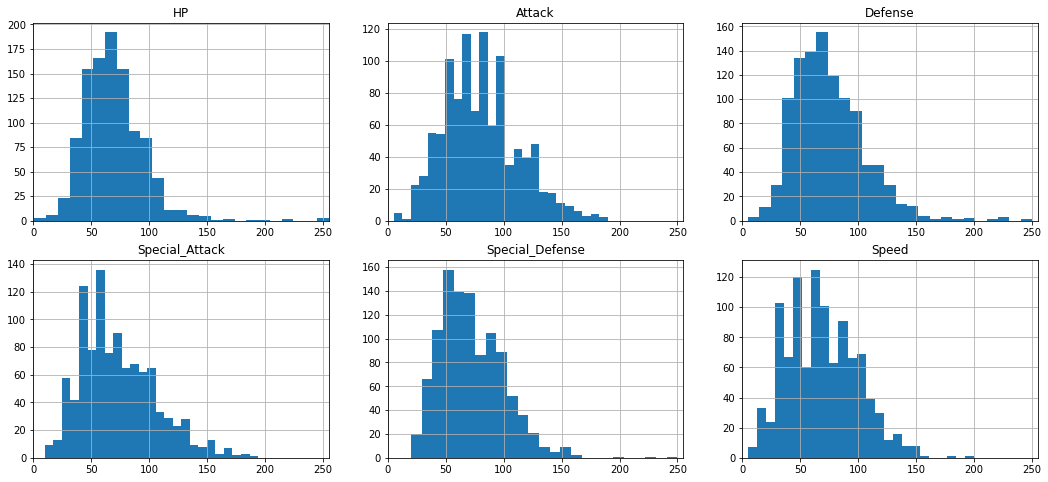

In [7]:
mycursor.execute(
    "SELECT HP, Attack, Defense, Special_Attack, Special_Defense, Speed\
    FROM pokemon"
)

all_stats = {
    'HP': [], 
    'Attack': [],  
    'Defense': [], 
    'Special_Attack': [],  
    'Special_Defense': [], 
    'Speed': []
}
for row in mycursor.fetchall(): 
    for i, key in enumerate(all_stats.keys()): 
        all_stats[key].append(row[i])

# histogram
keys = list(all_stats.keys())
fig, axes = plt.subplots(2, 3, figsize=(18,8))
for i, ax in enumerate(axes.ravel()):  # for some reason u need .ravel()
    ax.hist(all_stats[keys[i]], bins=25)
    ax.set_title(keys[i])
    ax.grid(True)
    ax.set_xlim(0, 255)

# find out the number battle a pokemon won or participated 

In [38]:
def number_of_wins(cursor, pokemon): 
    query_str = f"""
        SELECT count(*) from battle 
        WHERE 
        (pokemon1 = '{pokemon}' and pokemon1_win = 1) 
        or 
        (pokemon2 = '{pokemon}' and pokemon1_win = 0)
    """
    try: 
        cursor.execute(query_str)
    except mysql.connector.Error as err:
        raise err
    return cursor.fetchall()


number_of_wins(cursor=mycursor, pokemon='pikachu')

[(3,)]

In [39]:
def number_of_battles(cursor, pokemon): 
    query_str = f"""
        SELECT count(*) from battle 
        WHERE pokemon1 = '{pokemon}' or pokemon2 = '{pokemon}'
    """
    try: 
        cursor.execute(query_str)
    except mysql.connector.Error as err:
        raise err
    return cursor.fetchall()


number_of_battles(cursor=mycursor, pokemon='pikachu')

[(13,)]